In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from keras.regularizers import l2
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense
from prophet import Prophet
from keras.layers import BatchNormalization
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.svm import SVR
# from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
# Load dataset
data = pd.read_csv("/content/drive/MyDrive/Mini Project/BTC-Daily.csv")
data

unix                 date   symbol      open      high       low  \
0     1646092800  2022-03-01 00:00:00  BTC/USD  43221.71  43626.49  43185.48   
1     1646006400  2022-02-28 00:00:00  BTC/USD  37717.10  44256.08  37468.99   
2     1645920000  2022-02-27 00:00:00  BTC/USD  39146.66  39886.92  37015.74   
3     1645833600  2022-02-26 00:00:00  BTC/USD  39242.64  40330.99  38600.00   
4     1645747200  2022-02-25 00:00:00  BTC/USD  38360.93  39727.97  38027.61   
...          ...                  ...      ...       ...       ...       ...   
2646  1417478400  2014-12-02 00:00:00  BTC/USD    378.39    382.86    375.23   
2647  1417392000  2014-12-01 00:00:00  BTC/USD    376.40    382.31    373.03   
2648  1417305600  2014-11-30 00:00:00  BTC/USD    376.57    381.99    373.32   
2649  1417219200  2014-11-29 00:00:00  BTC/USD    376.42    386.60    372.25   
2650  1417132800  2014-11-28 00:00:00  BTC/USD    363.59    381.34    360.57   

         close    Volume BTC    Volume USD  
0     43185.48  4.900629e+01  2.116360e+06  
1     43178.98  3.160618e+03  1.364723e+08  
2     37712.68  1.701817e+03  6.418008e+07  
3     39146.66  9.127241e+02  3.573010e+07  
4     39231.64  2.202852e+03  8.642149e+07  
...        ...           ...           ...  
2646    379.25  2.593576e+06  6.832530e+03  
2647    378.39  2.520662e+06  6.660560e+03  
2648    373.34  1.145567e+06  3.046330e+03  
2649    376.72  2.746157e+06  7.245190e+03  
2650    376.28  3.220878e+06  8.617150e+03  

[2651 rows x 9 columns]

In [ ]:
data.head()

unix                 date   symbol      open      high       low  \
0  1646092800  2022-03-01 00:00:00  BTC/USD  43221.71  43626.49  43185.48   
1  1646006400  2022-02-28 00:00:00  BTC/USD  37717.10  44256.08  37468.99   
2  1645920000  2022-02-27 00:00:00  BTC/USD  39146.66  39886.92  37015.74   
3  1645833600  2022-02-26 00:00:00  BTC/USD  39242.64  40330.99  38600.00   
4  1645747200  2022-02-25 00:00:00  BTC/USD  38360.93  39727.97  38027.61   

      close   Volume BTC    Volume USD  
0  43185.48    49.006289  2.116360e+06  
1  43178.98  3160.618070  1.364723e+08  
2  37712.68  1701.817043  6.418008e+07  
3  39146.66   912.724087  3.573010e+07  
4  39231.64  2202.851827  8.642149e+07

In [ ]:
# Convert date column to datetime
data['date'] = pd.to_datetime(data['date'])

# Prepare data
X = data[['open', 'high', 'low', 'Volume BTC', 'Volume USD']].values
y = data['close'].values

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Normalize data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Random Forest model with hyperparameter tuning
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
rf_model = RandomForestRegressor(random_state=42)
rf_grid_search = GridSearchCV(rf_model, rf_param_grid, cv=3, scoring='neg_mean_absolute_error', verbose=2)
rf_grid_search.fit(X_train, y_train)
rf_model = rf_grid_search.best_estimator_
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

# Plotting predictions separately for each model
plt.figure(figsize=(7, 5))

# Random Forest
plt.plot(y_test, label='Actual')
plt.plot(rf_predictions, label='Random Forest', linestyle='-')
plt.title('Random Forest Predictions')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()

from sklearn.metrics import r2_score

# Calculate R-squared
rf_r2 = r2_score(y_test, rf_predictions)
print("Random Forest R-squared:", rf_r2)

rf_rmse = mean_squared_error(y_test, rf_predictions, squared=False)
print("Random Forest RMSE:", rf_rmse)


# Calculate MAPE for each model
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
rf_mape = calculate_mape(y_test, rf_predictions)
print("Random Forest:")
print("MAPE:", rf_mape)
print("Accuracy: ",100-rf_mape)
print()

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=   1.6s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=   1.3s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=   1.2s
[CV] END max_depth=None, min_samples_split=2, n_estimators=300; total time=   1.9s
[CV] END max_depth=None, min_samples_split=2, n_estimators=300; total time=   1.9s
[CV] END max_depth=None, min_samples_split=2, n_estimators=300; total time=   1.9s
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END max_depth=None, m

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=   1.2s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=   0.3s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=   1.5s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=200; total time=   4.1s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=200; total time=   0.9s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=200; total time=   0.5s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=300; total time=   2.8s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=300; total time=   3.1s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=300; total time=   3.4s
[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=100; total time=   1.8s
[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=100; total time=   0.1s
[CV] END ..learning_rate=0.05, max_depth=5, n_es

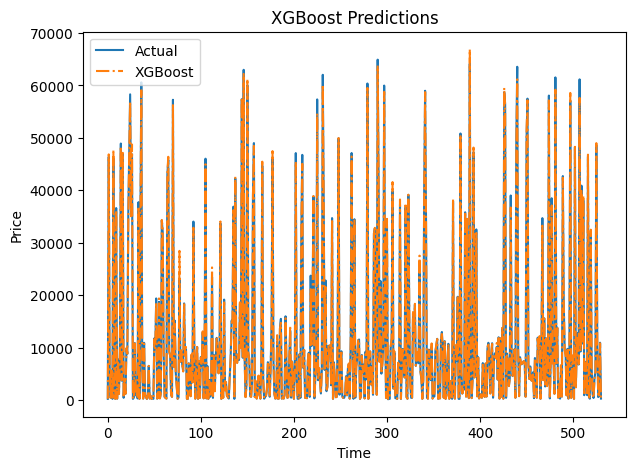

In [ ]:
# XGBoost model with hyperparameter tuning
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2]
}
xgb_model = XGBRegressor(random_state=42)
xgb_grid_search = GridSearchCV(xgb_model, xgb_param_grid, cv=3, scoring='neg_mean_absolute_error', verbose=2)
xgb_grid_search.fit(X_train, y_train)
xgb_model = xgb_grid_search.best_estimator_
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)


plt.figure(figsize=(7,5))


# XGBoost
# plt.subplot(3, 2, 2)
plt.plot(y_test, label='Actual')
plt.plot(xgb_predictions, label='XGBoost', linestyle='-.')
plt.title('XGBoost Predictions')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()


from sklearn.metrics import r2_score, mean_squared_error

# Calculate R-squared
xgb_r2 = r2_score(y_test, xgb_predictions)
print("XGBoost R-squared:", xgb_r2)

# Calculate RMSE
xgb_rmse = mean_squared_error(y_test, xgb_predictions, squared=False)
print("XGBoost RMSE:", xgb_rmse)


# Calculate MAPE for each model
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
xgb_mape = calculate_mape(y_test, xgb_predictions)

print()
print("XGBoost:")
print("MAPE:", xgb_mape)
print("Accuracy: ",100-xgb_mape)
print()




In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Linear Regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = lr.predict(X_test)

# Calculate evaluation metrics
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r_squared = r2_score(y_test, y_pred)
accuracy=100-mape
print("Accuracy:",accuracy)

print("Mean Absolute Percentage Error (MAPE):", mape)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (Coefficient of Determination):", r_squared)

# Plot actual vs predicted values
plt.figure(figsize=(7, 5))
plt.scatter(y_test, y_pred, color='blue', label='Actual vs Predicted')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', label='Perfect Prediction')
plt.title('Actual vs Predicted Bitcoin Prices')
plt.xlabel('Actual Price (USD)')
plt.ylabel('Predicted Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

Accuracy: 99.9840516057499
Mean Absolute Percentage Error (MAPE): 0.015948394250100886
Root Mean Squared Error (RMSE): 311.85386393900836
R-squared (Coefficient of Determination): 0.9996093213415641


In [ ]:
plt.figure(figsize=(10, 5))
# Plotting predictions from Random Forest
plt.plot(y_test, label='Actual')
plt.plot(rf_predictions, label='Random Forest', linestyle='-')
# Plotting predictions from XGBoost
plt.plot(xgb_predictions, label='XGBoost', linestyle='-.')
# Plotting predictions from Linear Regression
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Linear Regression', linestyle='--', color='orange')
plt.title('Bitcoin Price Predictions')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()